# Data Wrangling steps for the hospital readmission problem

## Data reading and initial inspection

In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
import sys
sys.path.append('icd9')
from icd9 import ICD9
import re

In [2]:
df = pd.read_csv('dataset_diabetes/diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
df.tail()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO
101765,443867222,175429310,Caucasian,Male,[70-80),?,1,1,7,6,...,No,No,No,No,No,No,No,No,No,NO


In [4]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [5]:
df.shape

(101766, 50)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

## Data Cleaning and Filling Missing Values

In [7]:
df.encounter_id.value_counts(dropna=False).head()

96210942     1
89943846     1
384306986    1
94650156     1
83156784     1
Name: encounter_id, dtype: int64

This means that each encounter_id is unique.

In [8]:
df.patient_nbr.value_counts(dropna=False).head()

88785891    40
43140906    28
23199021    23
1660293     23
88227540    23
Name: patient_nbr, dtype: int64

Some patients were admitted multiple times over the course of data collection.

In [9]:
df.race.value_counts(dropna=False)

Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

It appears that `?` is used for encoding missing values. Will replace it with proper NaN values.

In [10]:
df.replace('?', np.nan, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        99493 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      3197 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  61510 non-null object
medical_specialty           51817 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non

In [11]:
df.race.value_counts(dropna=False)

Caucasian          76099
AfricanAmerican    19210
NaN                 2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

`race` column will be encoded with integers. In addition a new column `race_na` will be created that identifies observations with the missing `race` values.

In [12]:
df.race = df.race.astype('category')
df['race'] = df.race.cat.codes + 1
df.race.value_counts(dropna=False)

3    76099
1    19210
0     2273
4     2037
5     1506
2      641
Name: race, dtype: int64

In [13]:
df['race_na'] = (df.race == 0).astype(int)
df.race_na.value_counts(dropna=False)

0    99493
1     2273
Name: race_na, dtype: int64

In [14]:
df.gender.value_counts(dropna=False)

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

Patients of 3 observations had `gender` values of `Unknown/Invalid`. They will be converted to NaN and treated as missing. The column will be reencoded with integer values, new column `gender_na` will label missing values.

In [15]:
df.loc[df.gender == 'Unknown/Invalid', 'gender'] = np.nan
df.gender.value_counts(dropna=False)

Female    54708
Male      47055
NaN           3
Name: gender, dtype: int64

In [16]:
df.gender = df.gender.astype('category')
df['gender'] = df.gender.cat.codes + 1
df.gender.value_counts(dropna=False)

1    54708
2    47055
0        3
Name: gender, dtype: int64

In [17]:
df['gender_na'] = (df.gender == 0).astype(int)
df.gender_na.value_counts(dropna=False)

0    101763
1         3
Name: gender_na, dtype: int64

In [18]:
df.age.value_counts(dropna=False)

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

`age` columns stores patient age binned in 10 year increments with no data missing. This columns will be reencoded with integer values in the order corresponding to the bin values.

In [19]:
age_cat_type = CategoricalDtype(categories=['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', 
                                                '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'],
                                ordered=True)
df.age = df.age.astype(age_cat_type)

In [20]:
df['age'] = df.age.cat.codes
df.age.value_counts(dropna=False)

7    26068
6    22483
5    17256
8    17197
4     9685
3     3775
9     2793
2     1657
1      691
0      161
Name: age, dtype: int64

In [21]:
df.weight.value_counts(dropna=False)

NaN          98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

`weight` column contains a lot of missing values. It will be dropped and eliminated from further analysis.

In [22]:
del df['weight']

In [23]:
df.admission_type_id.value_counts(dropna=False).sort_index()

1    53990
2    18480
3    18869
4       10
5     4785
6     5291
7       21
8      320
Name: admission_type_id, dtype: int64

The repository with the data contains file `IDs_mapping.csv` that describes encodings for `admission_type_id`, `discharge_disposition_id` and `admission_source_id`. The `admission_type_id`s with values 5, 6, and 8 are mapped to `Not Available`, `NULL`, and `Not Mapped` correspondingly. They will be treated as missing. Additional column `admission_type_id_na` will be created that identifies observations with missing `admission_type_id`s.

In [24]:
df['admission_type_id_na'] = df.admission_type_id.isin([5, 6, 8]).astype(int)
df.admission_type_id_na.value_counts(dropna=False)

0    91370
1    10396
Name: admission_type_id_na, dtype: int64

In [25]:
df.loc[df.admission_type_id.isin([5, 6, 8]), 'admission_type_id'] = 0
df.admission_type_id.value_counts(dropna=False)

1    53990
3    18869
2    18480
0    10396
7       21
4       10
Name: admission_type_id, dtype: int64

In [26]:
df.discharge_disposition_id.value_counts(dropna=False)

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

`discharge_disposition_id` values 18, 25, and 26 encode `NULL`, `Not Mapped`, `Unknown/Invalid`. They will be treated as missing and identified in `discharge_disposition_id_na` column.

In [27]:
df.loc[df.discharge_disposition_id.isin([18, 25, 26]), 'discharge_disposition_id'] = 0
df.discharge_disposition_id.value_counts(dropna=False)

1     60234
3     13954
6     12902
0      4680
2      2128
22     1993
11     1642
5      1184
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

In [28]:
# Labeling the missing discharge_disposition_id as 1 in a separate column.
df['discharge_disposition_id_na'] = (df.discharge_disposition_id == 0).astype(int)
df.discharge_disposition_id_na.value_counts()

0    97086
1     4680
Name: discharge_disposition_id_na, dtype: int64

In [29]:
df.admission_source_id.value_counts(dropna=False)

7     57494
1     29565
17     6781
4      3187
6      2264
2      1104
5       855
3       187
20      161
9       125
8        16
22       12
10        8
11        2
14        2
25        2
13        1
Name: admission_source_id, dtype: int64

`admission_source_id` encodes 9, 15, 17, 20, and 21 as ` Not Available`, `Not Available`, `NULL`, `Not Mapped`, and `Unknown/Invalid` correspondilngly. They will be labelled as missing and identified in `admission_source_id_na` column.

In [30]:
df.loc[df.admission_source_id.isin([9, 15, 17, 20, 21]), 'admission_source_id'] = 0
df.admission_source_id.value_counts(dropna=False)

7     57494
1     29565
0      7067
4      3187
6      2264
2      1104
5       855
3       187
8        16
22       12
10        8
25        2
14        2
11        2
13        1
Name: admission_source_id, dtype: int64

In [31]:
# Labeling the missing admission_source_id as 1 in a separate column.
df['admission_source_id_na'] = (df.admission_source_id == 0).astype(int)
df.admission_source_id_na.value_counts()

0    94699
1     7067
Name: admission_source_id_na, dtype: int64

In [32]:
df.time_in_hospital.value_counts(dropna=False)

3     17756
2     17224
1     14208
4     13924
5      9966
6      7539
7      5859
8      4391
9      3002
10     2342
11     1855
12     1448
13     1210
14     1042
Name: time_in_hospital, dtype: int64

`time_in_hospital` values are numeric without missing data. No adjustment is needed.

In [33]:
df.payer_code.value_counts(dropna=False).head()

NaN    40256
MC     32439
HM      6274
SP      5007
BC      4655
Name: payer_code, dtype: int64

`payer_code` will be encoded with integers. Missing values will be labeled in a separate column.

In [34]:
df.payer_code = df.payer_code.astype('category')
df['payer_code'] = df.payer_code.cat.codes + 1
df.payer_code.value_counts(dropna=False)

0     40256
8     32439
7      6274
15     5007
1      4655
9      3532
4      2533
16     2448
3      1937
11     1033
13      592
5       549
2       146
17      135
12       95
10       79
14       55
6         1
Name: payer_code, dtype: int64

In [35]:
df['payer_code_na'] = (df.payer_code == 0).astype(int)
df.payer_code_na.value_counts(dropna=False)

0    61510
1    40256
Name: payer_code_na, dtype: int64

In [36]:
df.medical_specialty.value_counts(dropna=False).head()

NaN                       49949
InternalMedicine          14635
Emergency/Trauma           7565
Family/GeneralPractice     7440
Cardiology                 5352
Name: medical_specialty, dtype: int64

`medical_specialty` will be encoded with integers, missing values will be labeled in a separate column.

In [37]:
df.medical_specialty = df.medical_specialty.astype('category')
df['medical_specialty'] = df.medical_specialty.cat.codes + 1
df.medical_specialty.value_counts(dropna=False).head()

0     49949
19    14635
9      7565
12     7440
4      5352
Name: medical_specialty, dtype: int64

In [38]:
df['medical_specialty_na'] = (df.medical_specialty == 0).astype(int)
df.medical_specialty_na.value_counts(dropna=False)

0    51817
1    49949
Name: medical_specialty_na, dtype: int64

In [39]:
df.max_glu_serum.value_counts(dropna=False)

None    96420
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

In `max_glu` column `None` identifies missing data. These values will be replaced with NaN values.

In [40]:
df.replace('None', np.nan, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 56 columns):
encounter_id                   101766 non-null int64
patient_nbr                    101766 non-null int64
race                           101766 non-null int64
gender                         101766 non-null int64
age                            101766 non-null int64
admission_type_id              101766 non-null int64
discharge_disposition_id       101766 non-null int64
admission_source_id            101766 non-null int64
time_in_hospital               101766 non-null int64
payer_code                     101766 non-null int64
medical_specialty              101766 non-null int64
num_lab_procedures             101766 non-null int64
num_procedures                 101766 non-null int64
num_medications                101766 non-null int64
number_outpatient              101766 non-null int64
number_emergency               101766 non-null int64
number_inpatient               101766 non

`max_glu_serum` values will be encoded with integers, such that their order order corresponds to the order of `max_glu_serum` values. Missing values will be identified in a separate column.

In [41]:
max_glu_serum_type = CategoricalDtype(categories=['Norm', '>200', '>300'],
                                      ordered=True)
df.max_glu_serum = df.max_glu_serum.astype(max_glu_serum_type)
df.max_glu_serum.value_counts(dropna=False)

NaN     96420
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

In [42]:
df['max_glu_serum'] = df.max_glu_serum.cat.codes + 1
df.max_glu_serum.value_counts(dropna=False)

0    96420
1     2597
2     1485
3     1264
Name: max_glu_serum, dtype: int64

In [43]:
df['max_glu_serum_na'] = (df.max_glu_serum == 0).astype(int)
df.max_glu_serum_na.value_counts(dropna=False)

1    96420
0     5346
Name: max_glu_serum_na, dtype: int64

In [44]:
df.A1Cresult.value_counts(dropna=False)

NaN     84748
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64

`A1Cresult` column contains missing values as well as ordered categories. This column will be reencoded with integers where the order of integers correspond to the order of values.

In [45]:
A1Cresult_type = CategoricalDtype(categories=['Norm', '>7', '>8'],
                                      ordered=True)
df.A1Cresult = df.A1Cresult.astype(A1Cresult_type)
df.A1Cresult.value_counts(dropna=False)

NaN     84748
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64

In [46]:
df['A1Cresult'] = df.A1Cresult.cat.codes + 1
df.A1Cresult.value_counts(dropna=False)

0    84748
3     8216
1     4990
2     3812
Name: A1Cresult, dtype: int64

In [47]:
df.metformin.value_counts(dropna=False)

No        81778
Steady    18346
Up         1067
Down        575
Name: metformin, dtype: int64

In [48]:
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
        'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
        'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
        'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
for drug in drugs:
    print(df[drug].value_counts(dropna=False))

No        81778
Steady    18346
Up         1067
Down        575
Name: metformin, dtype: int64
No        100227
Steady      1384
Up           110
Down          45
Name: repaglinide, dtype: int64
No        101063
Steady       668
Up            24
Down          11
Name: nateglinide, dtype: int64
No        101680
Steady        79
Up             6
Down           1
Name: chlorpropamide, dtype: int64
No        96575
Steady     4670
Up          327
Down        194
Name: glimepiride, dtype: int64
No        101765
Steady         1
Name: acetohexamide, dtype: int64
No        89080
Steady    11356
Up          770
Down        560
Name: glipizide, dtype: int64
No        91116
Steady     9274
Up          812
Down        564
Name: glyburide, dtype: int64
No        101743
Steady        23
Name: tolbutamide, dtype: int64
No        94438
Steady     6976
Up          234
Down        118
Name: pioglitazone, dtype: int64
No        95401
Steady     6100
Up          178
Down         87
Name: rosiglitazone, dty

The values of columns `citoglipton` and `examide` show identical values for all observations. These columns will be deleted from the dataset.

In [49]:
del df['citoglipton']
del df['examide']
drugs.remove('citoglipton')
drugs.remove('examide')

The columns with the drugs changes will be reencoded with integer values.

In [50]:
drug_type = CategoricalDtype(categories=['No', 'Steady', 'Up', 'Down'],
                                      ordered=False)
for drug in drugs:
    df[drug] = df[drug].astype(drug_type)
    df[drug] = df[drug].cat.codes

In [51]:
df.change.value_counts(dropna=False)

No    54755
Ch    47011
Name: change, dtype: int64

Columns `change` and `diabetesMed` will be reencoded with integer values.

In [52]:
df.change = (df.change == 'Ch').astype(int)
df.change.value_counts()

0    54755
1    47011
Name: change, dtype: int64

In [53]:
df.diabetesMed.value_counts(dropna=False)

Yes    78363
No     23403
Name: diabetesMed, dtype: int64

In [54]:
df.diabetesMed = (df.diabetesMed == 'Yes').astype(int)
df.diabetesMed.value_counts()

1    78363
0    23403
Name: diabetesMed, dtype: int64

In [55]:
df.readmitted.value_counts(dropna=False)

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

The column `readmitted` will be converted to integer values.

In [56]:
readmitted_type = CategoricalDtype(categories=['NO', '<30', '>30'],
                                  ordered=True)
df.readmitted = df.readmitted.astype(readmitted_type)
df.readmitted = df.readmitted.cat.codes
df.readmitted.value_counts()

0    54864
2    35545
1    11357
Name: readmitted, dtype: int64

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 55 columns):
encounter_id                   101766 non-null int64
patient_nbr                    101766 non-null int64
race                           101766 non-null int64
gender                         101766 non-null int64
age                            101766 non-null int64
admission_type_id              101766 non-null int64
discharge_disposition_id       101766 non-null int64
admission_source_id            101766 non-null int64
time_in_hospital               101766 non-null int64
payer_code                     101766 non-null int64
medical_specialty              101766 non-null int64
num_lab_procedures             101766 non-null int64
num_procedures                 101766 non-null int64
num_medications                101766 non-null int64
number_outpatient              101766 non-null int64
number_emergency               101766 non-null int64
number_inpatient               101766 non

In [58]:
df.diag_1.value_counts(dropna=False).head()

428    6862
414    6581
786    4016
410    3614
486    3508
Name: diag_1, dtype: int64

Columns `diag_1`, `diag_2` and `diag_3` contain medical ICD9 codes for primary diagnoses, secondary diagnoses and additional diagnoses correspondingly. The most common primary diagnosis for patient encounters in this dataset has a code of 428, which stands for 'Heart Failure'. The descriptions of these codes can be looked up at http://icd9cm.chrisendres.com/index.php?action=contents. These codes are often quite fine grained (they identify the diagnosis vary narrowly). It could be benefitial to have more general labels for the diagnoses since they could potentially be more predictive for hospital readmission than the very narrow diagnosis. In order to group diagnoses into larger groups on multiple levels, I used the script and data from the GitHub repo (https://github.com/sirrice/icd9.git), contents of which have been placed in `icd9` directory of the current repo. 

In [59]:
tree = ICD9('icd9/codes.json')

The values from the diagnosis columns in the hospital readmission dataset do not exactly match the values in the ICD9 dataset and need to be reformatted to enable merging. The ICD9 dataset will be converted to the pandas DataFrame that is capable of merging with the hospital readmission dataset.

In [60]:
def simplify_codes(codes):
    """Takes a series of codes, simplifies and pads them with zeros to be useful for searching in ICD9 database
    Args:
        codes: a Series of ICD9 codes in extended format
    Returns:
        List containing simplified and padded ICD9 codes. The order corresponds to the codes in the argument.
    """
    pat = '^([EV]?\\d\\d?\\d?\\.?\\d?).?'
    short_pat = '^(\\d*)'
    simple_codes = [re.search(pat, code).group(1) if type(code) == str else np.nan for code in codes]
    simple_codes_padded = [('0' * (3 - len(re.search(short_pat , code).group(1))) + code) if (type(code)==str and bool(re.search(short_pat , code).group())) else code for code in simple_codes]
    return simple_codes_padded


def struct_df_from_codes(codes, tree):
    """Converts a Series with simplified and padded medical ICD9 codes to a DataFrame with columns showing grouping of similar diagnoses
    Args:
        codes: a Series with simplified and padded ICD9 codes.
        tree: tree of ICD9 codes showing their hierarchical relationship. Obtained from https://github.com/sirrice/icd9.git
    Returns:
        DataFrame with columns showing grouping of diagnoses
    """
    code_list = []
    for code in codes:
        if code == code:
            if code[0] != 'E' and code[0] != 'V' and '.' not in code and int(code) not in list(range(910, 920)) + [235, 752]:
                code_parents = []
                for c in tree.find(code).parents:
                    code_parents.append(c.code)
                code_list.append([code] + code_parents + [np.nan] * (5 - len(code_parents)))
            elif code[0] == 'E' or code[0] == 'V' or '.' in code:
                code_parents = []
                for c in tree.find(code).parents:
                    code_parents.append(c.code)
                code_list.append([code] + code_parents + [np.nan] * (5 - len(code_parents)))
            elif int(code) in range(910, 920):
                code_parents = []
                for c in tree.find('905').parents[:-1]:
                    code_parents.append(c.code)
                code_list.append([code] + code_parents + [np.nan] * (5 - len(code_parents)))
            elif int(code) == 235:
                code_parents = []
                for c in tree.find('236').parents[:-1]:
                    code_parents.append(c.code)
                code_list.append([code] + code_parents + [np.nan] * (5 - len(code_parents)))
            elif int(code) == 752:
                code_parents = []
                for c in tree.find('751').parents[:-1]:
                    code_parents.append(c.code)
                code_list.append([code] + code_parents + [np.nan] * (5 - len(code_parents)))
            else:
                print('This code has not been added to the structure: {}'.format(code))
    out = pd.DataFrame(code_list).fillna(method='ffill', axis='columns')
    out.columns = ['simplified_code'] + ['level_{}'.format(n) for n in range(1, 6)]
    del out['level_1']
    return out
used_diagnoses = pd.concat([df.diag_1, df.diag_2, df.diag_3]).unique()
used_diagnoses = list(set(simplify_codes(used_diagnoses)))
code_df = struct_df_from_codes(used_diagnoses, tree)
code_df.head()

,simplified_code,level_2,level_3,level_4,level_5
0,258,240-279,249-259,258,258
1,201,140-239,200-208,201,201
2,212,140-239,210-229,212,212
3,458,390-459,451-459,458,458
4,642,630-679,640-649,642,642


In [61]:
# Converting columns with ICD9 diagnoses into simplified and padded format suitable for merging with ICD9 database
for n in range(1, 4):
    df['simple_diag_{}'.format(n)] = simplify_codes(df['diag_{}'.format(n)])
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,gender_na,admission_type_id_na,discharge_disposition_id_na,admission_source_id_na,payer_code_na,medical_specialty_na,max_glu_serum_na,simple_diag_1,simple_diag_2,simple_diag_3
0,2278392,8222157,3,1,0,0,0,1,1,0,...,0,1,1,0,1,0,1,250.8,NaN,NaN
1,149190,55629189,3,1,1,1,1,7,3,0,...,0,0,0,0,1,1,1,276,250.0,255
2,64410,86047875,1,1,2,1,1,7,2,0,...,0,0,0,0,1,1,1,648,250,V27
3,500364,82442376,3,2,3,1,1,7,2,0,...,0,0,0,0,1,1,1,008,250.4,403
4,16680,42519267,3,2,4,1,1,7,1,0,...,0,0,0,0,1,1,1,197,157,250


In [62]:
# Merging primary, secondary and additional secondary diagnoses with the ICD9 database
for n in range(1, 4):
    code_df_copy = code_df.copy()
    code_df_copy.columns = code_df_copy.columns + '_diag_{}'.format(n)
    df = df.merge(code_df_copy, how='left', left_on='simple_diag_{}'.format(n), right_on='simplified_code_diag_{}'.format(n))
    del df['simplified_code_diag_{}'.format(n)]
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,level_4_diag_1,level_5_diag_1,level_2_diag_2,level_3_diag_2,level_4_diag_2,level_5_diag_2,level_2_diag_3,level_3_diag_3,level_4_diag_3,level_5_diag_3
0,2278392,8222157,3,1,0,0,0,1,1,0,...,250,250.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,149190,55629189,3,1,1,1,1,7,3,0,...,276,276,240-279,249-259,250,250.0,240-279,249-259,255,255
2,64410,86047875,1,1,2,1,1,7,2,0,...,648,648,240-279,249-259,250,250,V20-V29,V27,V27,V27
3,500364,82442376,3,2,3,1,1,7,2,0,...,008,008,240-279,249-259,250,250.4,390-459,401-405,403,403
4,16680,42519267,3,2,4,1,1,7,1,0,...,197,197,140-239,150-159,157,157,240-279,249-259,250,250


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 70 columns):
encounter_id                   101766 non-null int64
patient_nbr                    101766 non-null int64
race                           101766 non-null int64
gender                         101766 non-null int64
age                            101766 non-null int64
admission_type_id              101766 non-null int64
discharge_disposition_id       101766 non-null int64
admission_source_id            101766 non-null int64
time_in_hospital               101766 non-null int64
payer_code                     101766 non-null int64
medical_specialty              101766 non-null int64
num_lab_procedures             101766 non-null int64
num_procedures                 101766 non-null int64
num_medications                101766 non-null int64
number_outpatient              101766 non-null int64
number_emergency               101766 non-null int64
number_inpatient               101766 non

The variables with the different levels of diagnosis will be converted to integer values.

In [64]:
columns_to_convert = ['diag_1', 'diag_2', 'diag_3', 'simple_diag_1', 'simple_diag_2', 'simple_diag_3', 
                      'level_2_diag_1', 'level_3_diag_1', 'level_4_diag_1', 'level_5_diag_1', 'level_2_diag_2',
                      'level_3_diag_2', 'level_4_diag_2', 'level_5_diag_2', 'level_2_diag_3',
                      'level_3_diag_3', 'level_4_diag_3', 'level_5_diag_3']
for c in columns_to_convert:
    df[c] = df[c].astype('category')
    df[c] = df[c].cat.codes + 1
    df['{}_na'.format(c)] = (df[c] == 0).astype(int)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 88 columns):
encounter_id                   101766 non-null int64
patient_nbr                    101766 non-null int64
race                           101766 non-null int64
gender                         101766 non-null int64
age                            101766 non-null int64
admission_type_id              101766 non-null int64
discharge_disposition_id       101766 non-null int64
admission_source_id            101766 non-null int64
time_in_hospital               101766 non-null int64
payer_code                     101766 non-null int64
medical_specialty              101766 non-null int64
num_lab_procedures             101766 non-null int64
num_procedures                 101766 non-null int64
num_medications                101766 non-null int64
number_outpatient              101766 non-null int64
number_emergency               101766 non-null int64
number_inpatient               101766 non

The dataset obtained after these procedures is clean, all numeric, has no missing values and ready for further exploratory data anslysis.

## Identification of outliers

In [66]:
df.describe()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,level_4_diag_1_na,level_5_diag_1_na,level_2_diag_2_na,level_3_diag_2_na,level_4_diag_2_na,level_5_diag_2_na,level_2_diag_3_na,level_3_diag_3_na,level_4_diag_3_na,level_5_diag_3_na
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,...,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.598776,1.462355,6.096702,1.451801,2.819832,4.578975,4.395987,4.885581,...,0.000206,0.000206,0.003518,0.003518,0.003518,0.003518,0.013983,0.013983,0.013983,0.013983
std,1.026403e+08,3.869636e+07,0.938415,0.498642,1.594084,0.910828,3.988644,2.945144,2.985108,4.823023,...,0.014364,0.014364,0.059208,0.059208,0.059208,0.059208,0.117421,0.117421,0.117421,0.117421
min,1.252200e+04,1.350000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.496119e+07,2.341322e+07,3.000000,1.000000,5.000000,1.000000,1.000000,1.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.523890e+08,4.550514e+07,3.000000,1.000000,6.000000,1.000000,1.000000,7.000000,4.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.302709e+08,8.754595e+07,3.000000,2.000000,7.000000,2.000000,3.000000,7.000000,6.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.438672e+08,1.895026e+08,5.000000,2.000000,9.000000,7.000000,28.000000,25.000000,14.000000,17.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


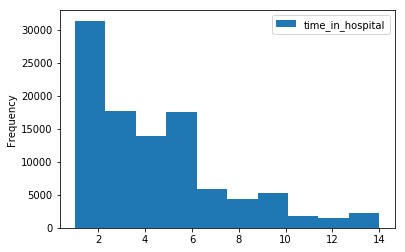

In [67]:
df[['time_in_hospital']].plot(kind='hist')

# Display the histogram
plt.show()


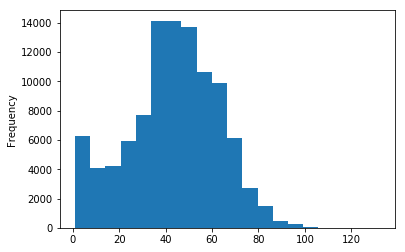

In [68]:
df['num_lab_procedures'].plot(kind='hist', bins=20)

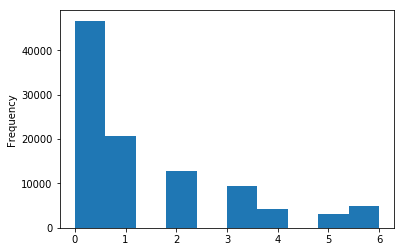

In [69]:
df['num_procedures'].plot(kind='hist')

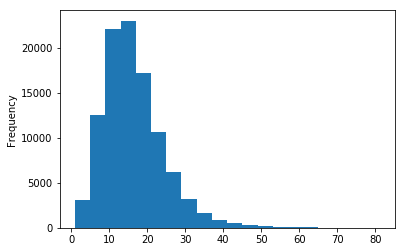

In [70]:
df['num_medications'].plot(kind='hist', bins=20)